# Overall Pipeline Algorithm

This pipeline has a large shift in its goal compared to previous iterations. Previously, the goal was always to find out the number of true stars. Now, it is being shifted instead to trying to figure out how many objects would be detected if survey property maps were constant over the whole map. This is obiously a huge shift in goals.

In order to accomplish this, four probability functions must be calculated. On top of this, two extra probability functions must be calculated for galaxy dependence verification tests. The probability functions are $P(C_S|O_S)$, $P(C_G|O_G)$, and relative detection rates for galaxies that get classified as stars, and stars that get classified as stars. The two extra functions for the verification test would be relative detection rates for galaxies that get classified as galaxies and stars that get classified as galaxies.

The overall pipeline will work as follows. First, balrog objects that pass quality cuts and an isochrone cut will be read in. Due to the nature of this new goal, far deeper limits on magnitude will be able to be used without introducing significant levels of noise. Magnitude bins will currently be assigned manually. This is something that could, and probably should, be changed in the future. Currently, we will focus on having multiple bins in areas where large shifts in the probability functions occur.

Once the magnitude bins are calculated, the probability functions will be calculated using a Gaussian kernel weighted interpolation scheme. PCA is used to orthogonalize the survey property maps. More hyper parameters related to this are available in one of the configuration files.

After this is done, gold catalog objects will be read in. A class cutoff of stars $\leq 1$ will be used for now since this is what is typically done in stellar stream searches. The class cutoff is important in this case and is not something that should have no impact on the final result, since the goal is no longer simply calculating the true number of stars, which is fixed by definition.

After this is done, the maximum likelihood formula from earlier will be used to go from classified object counts to observed object counts. As some new notation, $C_SfO_S$ will refer to classified stars coming from observed stars, which is equivalent to $C_S\cap O_S$. Switching the letters will behave as one would expect. To go from observed object counts to this is quite simple in the maximum likelihood approach. We would have $C_SfO_S = P(C_S|O_S)O_S$, and others like that. Keep in mind that $P(C_S|O_S)+P(C_G|O_S)$ is assumed to equal one (in reality, it is slightly less due to non classified objects, but it is close enough). From here, we will use relative detection rates to fully correct these object counts.

In [1]:
useMeasMagsForDet = True

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import fitsio
import astropy.io.fits as fits
from astropy.table import Table
import healpy as hp
import healsparse as hsp
import skyproj
from os import listdir
import astropy.units as u
from astropy.coordinates import SkyCoord
import Config
import StellarConfig as strConfig
from CropSurveyProperties import *
from GetObjects import *
from TrainAndFullMap import *

## Hyperparameters

In [3]:
res = strConfig.res
perCovered = strConfig.perCovered
numMagBins = strConfig.numMagBins
sigma = strConfig.sigma
perMap = strConfig.perMap
perVar = strConfig.perVar
numBins = strConfig.numBins
classCutoff = strConfig.classCutoff
goldCols = strConfig.goldCols
gCut = strConfig.gCut

deepCols = strConfig.deepCols

## Isochrone Configuration

In [4]:
path = strConfig.path
mu = strConfig.mu

## Files

In [5]:
matBalrFile = strConfig.matBalrFile
detBalrFile = strConfig.detBalrFile
matBalrStarFile = strConfig.matBalrStarFile
detBalrStarFile = strConfig.detBalrStarFile

matGalaFile = strConfig.matGalaFile

if useMeasMagsForDet:
    detGalaFile = strConfig.detGalaMeasDataFile
    detGalaAllPosFile = strConfig.detGalaAllPosFile
else:
    detGalaFile = strConfig.detGalaFile


matStarFile = strConfig.matStarFile

if useMeasMagsForDet:
    detStarFile = strConfig.detStarMeasDataFile
    detStarAllPosFile = strConfig.detStarAllPosFile
else:
    detStarFile = strConfig.detStarFile


deepFiles = strConfig.deepFiles

origCondFiles = strConfig.origCondFiles
stelFile = strConfig.stelFile
pixFile = strConfig.pixFile
condFiles = strConfig.condFiles

galaExtrFiles = strConfig.galaExtrFiles
galaTrainFiles = strConfig.galaTrainFiles
galaProbFiles = strConfig.galaProbFiles

if useMeasMagsForDet:
    galaDetExtrFiles = strConfig.galaDetMeasDataExtrFiles
    galaDetTrainFiles = strConfig.galaDetMeasDataTrainFiles
    galaDetProbFiles = strConfig.galaDetMeasDataProbFiles

    galaDetAsGalaExtrFiles = strConfig.galaDetMeasDataAsGalaExtrFiles
    galaDetAsGalaTrainFiles = strConfig.galaDetMeasDataAsGalaTrainFiles
    galaDetAsGalaProbFiles = strConfig.galaDetMeasDataAsGalaProbFiles
else:
    galaDetExtrFiles = strConfig.galaDetExtrFiles
    galaDetTrainFiles = strConfig.galaDetTrainFiles
    galaDetProbFiles = strConfig.galaDetProbFiles

    galaDetAsGalaExtrFiles = strConfig.galaDetAsGalaExtrFiles
    galaDetAsGalaTrainFiles = strConfig.galaDetAsGalaTrainFiles
    galaDetAsGalaProbFiles = strConfig.galaDetAsGalaProbFiles

galaDetAsAnyExtrFiles = strConfig.galaDetAsAnyExtrFiles
galaDetAsAnyTrainFiles = strConfig.galaDetAsAnyTrainFiles
galaDetAsAnyProbFiles = strConfig.galaDetAsAnyProbFiles

starExtrFiles = strConfig.starExtrFiles
starTrainFiles = strConfig.starTrainFiles
starProbFiles = strConfig.starProbFiles
    
if useMeasMagsForDet:
    starDetExtrFiles = strConfig.starDetMeasDataExtrFiles
    starDetTrainFiles = strConfig.starDetMeasDataTrainFiles
    starDetProbFiles = strConfig.starDetMeasDataProbFiles

    starDetAsGalaExtrFiles = strConfig.starDetMeasDataAsGalaExtrFiles
    starDetAsGalaTrainFiles = strConfig.starDetMeasDataAsGalaTrainFiles
    starDetAsGalaProbFiles = strConfig.starDetMeasDataAsGalaProbFiles
else:
    starDetExtrFiles = strConfig.starDetExtrFiles
    starDetTrainFiles = strConfig.starDetTrainFiles
    starDetProbFiles = strConfig.starDetProbFiles

    starDetAsGalaExtrFiles = strConfig.starDetAsGalaExtrFiles
    starDetAsGalaTrainFiles = strConfig.starDetAsGalaTrainFiles
    starDetAsGalaProbFiles = strConfig.starDetAsGalaProbFiles

starDetAsAnyExtrFiles = strConfig.starDetAsAnyExtrFiles
starDetAsAnyTrainFiles = strConfig.starDetAsAnyTrainFiles
starDetAsAnyProbFiles = strConfig.starDetAsAnyProbFiles

goldStarFiles = strConfig.goldStarFiles
goldGalaFiles = strConfig.goldGalaFiles

goldObjectsDir = strConfig.goldObjectsDir
goldObjectsFiles = strConfig.goldObjectsFiles

starPosFiles = strConfig.starPosFiles
galaPosFiles = strConfig.galaPosFiles
calibrationFile = strConfig.calibrationFile

goldMoreInfoStarFiles = strConfig.goldMoreInfoStarFiles
goldMoreInfoGalaFiles = strConfig.goldMoreInfoGalaFiles

In [6]:
data = fitsio.read(detBalrStarFile)

## Get Synthetic Objects

In [7]:
# getMatStars(path, mu, matBalrStarFile, detBalrStarFile, matStarFile, gCut, classCutoff)
# if useMeasMagsForDet:
#     getDetStarsMeasData(path, mu, matBalrStarFile, detBalrStarFile, detStarFile, detStarAllPosFile, gCut, classCutoff)
# else:
#     getDetStar(path, mu, detBalrStarFile, detStarFile, gCut)

# getMatGalas(path, mu, deepFiles, matBalrFile, detBalrFile, matGalaFile, gCut, classCutoff)
# if useMeasMagsForDet:
#     getDetGalasMeasData(path, mu, deepFiles, matBalrFile, detBalrFile, detGalaFile, detGalaAllPosFile, gCut, classCutoff)
# else:
#     getDetGalas(path, mu, deepFiles, detBalrFile, detGalaFile, gCut)

# Read Before Continuing:

At this point, the magnitude bins have to be decided. Uncomment the next few cells before the next markdown cell to generate the necessary plots for making a decision.

In [8]:
# matStarData = fitsio.read(matStarFile)
# matGalaData = fitsio.read(matGalaFile)
# detStarData = fitsio.read(detStarFile)
# detGalaData = fitsio.read(detGalaFile)

# matStarRMAG = matStarData['RMAG']
# matStarDET = np.zeros_like(matStarRMAG)
# matStarDET[np.where(matStarData['CLASS'] < classCutoff)[0]] = 1

# matGalaRMAG = matGalaData['RMAG']
# matGalaDET = np.zeros_like(matGalaRMAG)
# matGalaDET[np.where(matGalaData['CLASS'] > classCutoff)[0]] = 1

# detStarRMAG = detStarData['RMAG']
# detStarDET = np.zeros_like(detStarRMAG)
# detStarDET[np.where((detStarData['CLASS'] < classCutoff) & (detStarData['CLASS'] >= 0))[0]] = 1

# detGalaRMAG = detGalaData['RMAG']
# detGalaDET = np.zeros_like(detGalaRMAG)
# detGalaDET[np.where((detGalaData['CLASS'] < classCutoff) & (detGalaData['CLASS'] >= 0))[0]] = 1

In [9]:
# xMatStar = np.linspace(np.average(matStarRMAG)-3*np.std(matStarRMAG), np.average(matStarRMAG)+3*np.std(matStarRMAG), numBins)
# xMatStar = xMatStar[np.where((xMatStar <= np.max(matStarRMAG)) & (xMatStar >= np.min(matStarRMAG)))[0]]
# matStarSigma = sigma * np.std(matStarRMAG)
# yMatStar = []

# for xi in xMatStar:
#     # Gaussian weighting the values close by to each x value.
#     totCor = np.sum(matStarDET * np.exp(-1*(((matStarRMAG - xi) / matStarSigma)**2)))
#     totAll = np.sum(np.exp(-1*(((matStarRMAG - xi) / matStarSigma)**2)))
#     yMatStar.append(totCor / totAll)

# yMatStar = np.array(yMatStar)

# xDetStar = np.linspace(np.average(detStarRMAG)-3*np.std(detStarRMAG), np.average(detStarRMAG)+3*np.std(detStarRMAG), numBins)
# xDetStar = xDetStar[np.where((xDetStar <= np.max(detStarRMAG)) & (xDetStar >= np.min(detStarRMAG)))[0]]
# detStarSigma = sigma * np.std(detStarRMAG)
# yDetStar = []

# for xi in xDetStar:
#     # Gaussian weighting the values close by to each x value.
#     totCor = np.sum(detStarDET * np.exp(-1*(((detStarRMAG - xi) / detStarSigma)**2)))
#     totAll = np.sum(np.exp(-1*(((detStarRMAG - xi) / detStarSigma)**2)))
#     yDetStar.append(totCor / totAll)

# yDetStar = np.array(yDetStar)

# xMatGala = np.linspace(np.average(matGalaRMAG)-3*np.std(matGalaRMAG), np.average(matGalaRMAG)+3*np.std(matGalaRMAG), numBins)
# xMatGala = xMatGala[np.where((xMatGala <= np.max(matGalaRMAG)) & (xMatGala >= np.min(matGalaRMAG)))[0]]
# matGalaSigma = sigma * np.std(matGalaRMAG)
# yMatGala = []

# for xi in xMatGala:
#     # Gaussian weighting the values close by to each x value.
#     totCor = np.sum(matGalaDET * np.exp(-1*(((matGalaRMAG - xi) / matGalaSigma)**2)))
#     totAll = np.sum(np.exp(-1*(((matGalaRMAG - xi) / matGalaSigma)**2)))
#     yMatGala.append(totCor / totAll)

# yMatGala = np.array(yMatGala)

# xDetGala = np.linspace(np.average(detGalaRMAG)-3*np.std(detGalaRMAG), np.average(detGalaRMAG)+3*np.std(detGalaRMAG), numBins)
# xDetGala = xDetGala[np.where((xDetGala <= np.max(detGalaRMAG)) & (xDetGala >= np.min(detGalaRMAG)))[0]]
# detGalaSigma = sigma * np.std(detGalaRMAG)
# yDetGala = []

# for xi in xDetGala:
#     # Gaussian weighting the values close by to each x value.
#     totCor = np.sum(detGalaDET * np.exp(-1*(((detGalaRMAG - xi) / detGalaSigma)**2)))
#     totAll = np.sum(np.exp(-1*(((detGalaRMAG - xi) / detGalaSigma)**2)))
#     yDetGala.append(totCor / totAll)

# yDetGala = np.array(yDetGala)

In [10]:
# plt.figure(dpi = 120)
# plt.plot(xMatGala, yMatGala, zorder = 3, label = 'Galaxy Correct Classification Rate')
# plt.plot(xDetGala, yDetGala, zorder = 3, label = 'Galaxy Stellar Detection Rate')
# plt.plot(xMatStar, yMatStar, zorder = 3, label = 'Star Correct Classification Rate')
# plt.plot(xDetStar, yDetStar, zorder = 3, label = 'Star Stellar Detection Rate')
# plt.xlabel('r Band Magnitude')
# plt.ylabel('Percent')
# plt.legend()
# plt.grid(zorder = 0)
# # plt.ylim([0, 1])
# plt.show()

In [11]:
magBins = [22, 23, 23.5, 24, 24.5, 25]

## Get Pixels and Conditions

In [12]:
# validPixCropData(res, origCondFiles, stelFile, pixFile, condFiles, perCovered)

In [5]:
(55*91 + 90) % 91

90

In [13]:
validPix = fitsio.read(pixFile)['PIXEL']
pixCheck = np.full(12*(res**2), False, dtype = bool)
pixCheck[validPix] = True

## Training

In [14]:
# singleCorrectionTrain(matStarFile, condFiles, pixFile, magBins, starTrainFiles, starProbFiles, starExtrFiles, sigma, perMap, perVar, numBins, res, True, classCutoff)
for starTrainFile in starTrainFiles:
    print(loadtxt(starTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9723821409879625
0.8675420019765636
0.7029195603802846
0.636183110367893
0.6103174899966344
0.539373037128379


In [15]:
# if useMeasMagsForDet:
#     singleCorrectionTrainNMethod(detStarFile, condFiles, pixFile, magBins, detStarAllPosFile, starDetTrainFiles, starDetProbFiles, starDetExtrFiles, sigma, perMap, perVar, numBins, res, True, classCutoff)
# else:
#     singleCorrectionTrain(detStarFile, condFiles, pixFile, magBins, starDetTrainFiles, starDetProbFiles, starDetExtrFiles, sigma, perMap, perVar, numBins, res, True, classCutoff)
aveStarDet = []
for starDetTrainFile in starDetTrainFiles:
    aveStarDet.append(loadtxt(starDetTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    print(aveStarDet[-1])

0.6557523925880676
0.4170773094413901
0.28303807778456525
0.578415801262472
0.8862010452725175
0.3800176474580873


In [16]:
# if useMeasMagsForDet:
#     singleCorrectionTrainNMethod(detStarFile, condFiles, pixFile, magBins, detStarAllPosFile, starDetAsGalaTrainFiles, starDetAsGalaProbFiles, starDetAsGalaExtrFiles, sigma, perMap, perVar, numBins, res, False, classCutoff)
# else:
#     singleCorrectionTrain(detStarFile, condFiles, pixFile, magBins, starDetAsGalaTrainFiles, starDetAsGalaProbFiles, starDetAsGalaExtrFiles, sigma, perMap, perVar, numBins, res, False, classCutoff)
aveStarDetAsGala = []
for starDetAsGalaTrainFile in starDetAsGalaTrainFiles:
    aveStarDetAsGala.append(loadtxt(starDetAsGalaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    print(aveStarDetAsGala[-1])

0.018624855765967556
0.06368017375958732
0.11962261589628724
0.330767664426797
0.5658318061494604
0.3245367542252087


In [17]:
# singleCorrectionTrain(detStarFile, condFiles, pixFile, magBins, starDetAsAnyTrainFiles, starDetAsAnyProbFiles, starDetAsAnyExtrFiles, sigma, perMap, perVar, numBins, res, True, 3.5)

In [18]:
# singleCorrectionTrain(matGalaFile, condFiles, pixFile, magBins, galaTrainFiles, galaProbFiles, galaExtrFiles, sigma, perMap, perVar, numBins, res, False, classCutoff)
for galaTrainFile in galaTrainFiles:
    print(loadtxt(galaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=','))

0.9136819776454271
0.9760871704745167
0.9596600522996462
0.9258348162880771
0.8780162669325474
0.8288864769447294


In [19]:
# if useMeasMagsForDet:
#     singleCorrectionTrainNMethod(detGalaFile, condFiles, pixFile, magBins, detGalaAllPosFile, galaDetTrainFiles, galaDetProbFiles, galaDetExtrFiles, sigma, perMap, perVar, numBins, res, True, classCutoff)
# else:
#     singleCorrectionTrain(detGalaFile, condFiles, pixFile, magBins, galaDetTrainFiles, galaDetProbFiles, galaDetExtrFiles, sigma, perMap, perVar, numBins, res, True, classCutoff)
aveGalaDet = []
for galaDetTrainFile in galaDetTrainFiles:
    aveGalaDet.append(loadtxt(galaDetTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    print(aveGalaDet[-1])

0.04239801234271059
0.08519676204215756
0.17865873206700328
0.44007974673399053
0.6692313857497796
0.2874589244209345


In [20]:
# if useMeasMagsForDet:
#     singleCorrectionTrainNMethod(detGalaFile, condFiles, pixFile, magBins, detGalaAllPosFile, galaDetAsGalaTrainFiles, galaDetAsGalaProbFiles, galaDetAsGalaExtrFiles, sigma, perMap, perVar, numBins, res, False, classCutoff)
# else:
#     singleCorrectionTrain(detGalaFile, condFiles, pixFile, magBins, galaDetAsGalaTrainFiles, galaDetAsGalaProbFiles, galaDetAsGalaExtrFiles, sigma, perMap, perVar, numBins, res, False, classCutoff)
aveGalaDetAsGala = []
for galaDetAsGalaTrainFile in galaDetAsGalaTrainFiles:
    aveGalaDetAsGala.append(loadtxt(galaDetAsGalaTrainFile[0:-5] + '_Ave_Acc.csv', delimiter=',').astype(float))
    print(aveGalaDetAsGala[-1])

0.44878576580908874
3.4776088001923537
4.250170313376613
5.49369840506532
4.817003286046325
1.3924721487537068


In [20]:
# singleCorrectionTrain(detGalaFile, condFiles, pixFile, magBins, galaDetAsAnyTrainFiles, galaDetAsAnyProbFiles, galaDetAsAnyExtrFiles, sigma, perMap, perVar, numBins, res, True, 3.5)

## Get Gold Objects

In [21]:
# StarPIX = []
# GalaPIX = []

# StarRA = []
# StarDEC = []

# GalaRA = []
# GalaDEC = []

# StarRMAG = []
# StarGMAG = []

# GalaRMAG = []
# GalaGMAG = []

# for _ in range(numMagBins):
    
#     StarPIX.append(np.array([]))
#     StarRA.append(np.array([]))
#     StarDEC.append(np.array([]))
#     StarRMAG.append(np.array([]))
#     StarGMAG.append(np.array([]))
    
#     GalaPIX.append(np.array([]))
#     GalaRA.append(np.array([]))
#     GalaDEC.append(np.array([]))
#     GalaRMAG.append(np.array([]))
#     GalaGMAG.append(np.array([]))
    
# for j in range(len(goldObjectsFiles)):
#     if j%100 == 0:
#         print(j)
#     obsData = fitsio.read(goldObjectsDir + goldObjectsFiles[j], columns = goldCols)
#     FOREGROUND = obsData[goldCols[0]]
#     BADREGIONS = obsData[goldCols[1]]
#     FOOTPRINT = obsData[goldCols[2]]
#     CLASS = obsData[goldCols[3]]
#     GMAG = obsData[goldCols[4]]
#     RMAG = obsData[goldCols[5]]
#     GMAG_GALA = obsData[goldCols[6]]
#     RMAG_GALA = obsData[goldCols[7]]
#     RA = obsData[goldCols[8]]
#     DEC = obsData[goldCols[9]]
#     PIX = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

#     # General Quality Cuts
#     qualityCut = np.where((FOREGROUND == 0) &
#                           (BADREGIONS < 2) &
#                           (FOOTPRINT == 1) &
#                           (pixCheck[PIX]))[0]

#     CLASS = CLASS[qualityCut]
#     GMAG = GMAG[qualityCut]
#     RMAG = RMAG[qualityCut]
#     GMAG_GALA = GMAG_GALA[qualityCut]
#     RMAG_GALA = RMAG_GALA[qualityCut]
#     PIX = PIX[qualityCut]
#     RA = RA[qualityCut]
#     DEC = DEC[qualityCut]

#     # Observed Star Objects

#     blueStarCut = np.where((CLASS <= classCutoff) & 
#                       (CLASS >= 0) &
#                       (GMAG < gCut))[0]

#     STARRA = RA[blueStarCut]
#     STARDEC = DEC[blueStarCut]
#     STARPIX = PIX[blueStarCut]
#     STARGMAG = GMAG[blueStarCut]
#     STARRMAG = RMAG[blueStarCut]
    
#     for i in np.arange(numMagBins):
        
#         if i == 0:
#             maxRMAG = magBins[i]
#             magCut = np.where(STARRMAG <= maxRMAG)[0]
#         else:
#             minRMAG = magBins[i - 1]
#             maxRMAG = magBins[i]
#             magCut = np.where((STARRMAG <= maxRMAG) & (STARRMAG > minRMAG))[0]
        
#         magStarRa = STARRA[magCut]
#         magStarDec = STARDEC[magCut]
#         magStarGmag = STARGMAG[magCut]
#         magStarRmag = STARRMAG[magCut]
#         magStarPix = STARPIX[magCut]

#         isoStarCut = Path.contains_points(path,np.vstack((magStarGmag - magStarRmag, magStarGmag - mu)).T)

#         StarRA[i] = np.append(StarRA[i], magStarRa[isoStarCut])
#         StarDEC[i] = np.append(StarDEC[i], magStarDec[isoStarCut])
#         StarPIX[i] = np.append(StarPIX[i], magStarPix[isoStarCut])
#         StarRMAG[i] = np.append(StarRMAG[i], magStarRmag[isoStarCut])
#         StarGMAG[i] = np.append(StarGMAG[i], magStarGmag[isoStarCut])

#     # Observed Galaxy Objects

#     blueGalaCut = np.where((CLASS <= 3) & 
#                       (CLASS >= classCutoff) &
#                       (GMAG_GALA < gCut))[0]

#     GALARA = RA[blueGalaCut]
#     GALADEC = DEC[blueGalaCut]
#     GALAPIX = PIX[blueGalaCut]
#     GALAGMAG = GMAG_GALA[blueGalaCut]
#     GALARMAG = RMAG_GALA[blueGalaCut]
    
#     for i in np.arange(numMagBins):
        
#         if i == 0:
#             maxRMAG = magBins[i]
#             magCut = np.where(GALARMAG <= maxRMAG)[0]
#         else:
#             minRMAG = magBins[i - 1]
#             maxRMAG = magBins[i]
#             magCut = np.where((GALARMAG <= maxRMAG) & (GALARMAG > minRMAG))[0]
        
#         magGalaRa = GALARA[magCut]
#         magGalaDec = GALADEC[magCut]
#         magGalaGmag = GALAGMAG[magCut]
#         magGalaRmag = GALARMAG[magCut]
#         magGalaPix = GALAPIX[magCut]

#         isoGalaCut = Path.contains_points(path,np.vstack((magGalaGmag - magGalaRmag, magGalaGmag - mu)).T)

#         GalaRA[i] = np.append(GalaRA[i], magGalaRa[isoGalaCut])
#         GalaDEC[i] = np.append(GalaDEC[i], magGalaDec[isoGalaCut])
#         GalaPIX[i] = np.append(GalaPIX[i], magGalaPix[isoGalaCut])
#         GalaRMAG[i] = np.append(GalaRMAG[i], magGalaRmag[isoGalaCut])
#         GalaGMAG[i] = np.append(GalaGMAG[i], magGalaGmag[isoGalaCut])

# for i in range(numMagBins):
#     my_table = Table()
#     my_table['RA'] = StarRA[i].astype(float)
#     my_table['DEC'] = StarDEC[i].astype(float)
#     my_table['RMAG'] = StarRMAG[i].astype(float)
#     my_table['GMAG'] = StarGMAG[i].astype(float)
#     my_table.write(goldMoreInfoStarFiles[i], overwrite = True)
    
#     my_table = Table()
#     my_table['RA'] = GalaRA[i].astype(float)
#     my_table['DEC'] = GalaDEC[i].astype(float)
#     my_table['RMAG'] = GalaRMAG[i].astype(float)
#     my_table['GMAG'] = GalaGMAG[i].astype(float)
#     my_table.write(goldMoreInfoGalaFiles[i], overwrite = True)

In [22]:
# for j in np.arange(len(StarPIX)):

#     starPixRepeats = StarPIX[j]
#     sortInds = starPixRepeats.argsort()
#     starPixRepeats = starPixRepeats[sortInds[::1]]

#     # These are indices that will be looping through the pixStar and starPix arrays in parallel.
#     uniqInd = 0
#     starInd = 0

#     # This will be used to store the number of stars at each pixel.
#     starPix = np.unique(starPixRepeats) # The unique pixels, with no repeats.
#     starDet = np.zeros_like(starPix)

#     while starInd < len(starPixRepeats):
#         if starPix[uniqInd] == starPixRepeats[starInd]: # If the pixels match up in the arrays.
#             starDet[uniqInd] += 1                # Add one for the detection..
#             starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
#             # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
#             # making this the index that we must restrict in the while loop.
#         else:
#             uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

#     fullSkyStars = np.full(12*(res**2), 0.0)
#     fullSkyStars[starPix.astype(int)] = starDet

#     my_table = Table()
#     my_table['SIGNAL'] = fullSkyStars[validPix]
#     my_table.write(goldStarFiles[j], overwrite = True)

In [23]:
# for j in np.arange(len(GalaPIX)):

#     galaPixRepeats = GalaPIX[j]
#     sortInds = galaPixRepeats.argsort()
#     galaPixRepeats = galaPixRepeats[sortInds[::1]]

#     # These are indices that will be looping through the pixStar and starPix arrays in parallel.
#     uniqInd = 0
#     galaInd = 0

#     # This will be used to store the number of stars at each pixel.
#     galaPix = np.unique(galaPixRepeats) # The unique pixels, with no repeats.
#     galaDet = np.zeros_like(galaPix)

#     while galaInd < len(galaPixRepeats):
#         if galaPix[uniqInd] == galaPixRepeats[galaInd]: # If the pixels match up in the arrays.
#             galaDet[uniqInd] += 1                # Add one for the detection..
#             galaInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
#             # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
#             # making this the index that we must restrict in the while loop.
#         else:
#             uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.

#     fullSkyGalas = np.full(12*(res**2), 0.0)
#     fullSkyGalas[galaPix.astype(int)] = galaDet

#     my_table = Table()
#     my_table['SIGNAL'] = fullSkyGalas[validPix]
#     my_table.write(goldGalaFiles[j], overwrite = True)

## Deep Field Calibrations

In [24]:
def findMatches(angleCutoff, RASource, DECSource, RAMatchCatalog, DECMatchCatalog, nthneighbor=1):
    c = SkyCoord(ra=RASource*u.degree, dec=DECSource*u.degree)
    catalog = SkyCoord(ra=RAMatchCatalog*u.degree, dec=DECMatchCatalog*u.degree)
    idx, d2d, d3d = c.match_to_catalog_sky(catalog, nthneighbor=nthneighbor)
    matches = d2d < angleCutoff
    return matches, d2d

In [25]:
# deepRA = np.array([])
# deepDEC = np.array([])
# deepClass = np.array([])
# deepFlag = np.array([])
# deepFlagNir = np.array([])

# for deepFile in deepFiles:
#     deepData = fitsio.read(deepFile, columns = deepCols)

#     deepRA = np.append(deepRA, deepData['RA'])
#     deepDEC = np.append(deepDEC, deepData['DEC'])
#     deepClass = np.append(deepClass, deepData['KNN_CLASS'])
#     deepFlag = np.append(deepFlag, deepData['MASK_FLAGS'])
#     deepFlagNir = np.append(deepFlagNir, deepData['MASK_FLAGS_NIR'])

# deepFlagCuts = np.where((deepFlag == 0) &
#                         (deepFlagNir == 0) &
#                         (deepRA < 120) &
#                         (deepClass > 0) &
#                         (deepClass <= 3))[0]

# deepRA = deepRA[deepFlagCuts]
# deepDEC = deepDEC[deepFlagCuts]
# deepClass = deepClass[deepFlagCuts]

# if len(np.where(deepClass == 3)[0]) != 0:
#     print('WARNING: Objects with no class are present in this deep field selection. ' + str(len(np.where(deepClass == 3)[0])) + ' object(s) out of ' + str(len(deepClass)) + ' have an ambiguous classification.')

# deepPix = np.unique(hp.ang2pix(res, deepRA, deepDEC, lonlat = True, nest = True))

# deepPixCheck = np.full(12*(res**2), False, dtype = bool)
# deepPixCheck[deepPix] = True

In [26]:
# UNUSED CODE

# print(len(goldObjectsFiles))
    
# StarRA = []
# StarDEC = []

# GalaRA = []
# GalaDEC = []

# for _ in range(numMagBins):
#     StarRA.append(np.array([]))
#     StarDEC.append(np.array([]))
#     GalaRA.append(np.array([]))
#     GalaDEC.append(np.array([]))

# for j in range(len(goldObjectsFiles)):
#     if j%100 == 0:
#         print(j)
#     obsData = fitsio.read(goldObjectsDir + goldObjectsFiles[j], columns = goldCols)
#     FOREGROUND = obsData[goldCols[0]]
#     BADREGIONS = obsData[goldCols[1]]
#     FOOTPRINT = obsData[goldCols[2]]
#     CLASS = obsData[goldCols[3]]
#     GMAG = obsData[goldCols[4]]
#     RMAG = obsData[goldCols[5]]
#     GMAG_GALA = obsData[goldCols[6]]
#     RMAG_GALA = obsData[goldCols[7]]
#     RA = obsData[goldCols[8]]
#     DEC = obsData[goldCols[9]]
#     PIX = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

#     # General Quality Cuts
#     qualityCut = np.where((FOREGROUND == 0) &
#                           (BADREGIONS < 2) &
#                           (FOOTPRINT == 1) &
#                           (deepPixCheck[PIX]) &
#                           (pixCheck[PIX]))[0]

#     CLASS = CLASS[qualityCut]
#     GMAG = GMAG[qualityCut]
#     RMAG = RMAG[qualityCut]
#     GMAG_GALA = GMAG_GALA[qualityCut]
#     RMAG_GALA = RMAG_GALA[qualityCut]
#     PIX = PIX[qualityCut]
#     RA = RA[qualityCut]
#     DEC = DEC[qualityCut]

#     # Observed Star Objects

#     blueStarCut = np.where((CLASS <= classCutoff) & 
#                       (CLASS >= 0) &
#                       (GMAG < gCut))[0]

#     STARRA = RA[blueStarCut]
#     STARDEC = DEC[blueStarCut]
#     STARGMAG = GMAG[blueStarCut]
#     STARRMAG = RMAG[blueStarCut]
    
#     for i in np.arange(numMagBins):
        
#         if i == 0:
#             maxRMAG = magBins[i]
#             magCut = np.where(STARRMAG <= maxRMAG)[0]
#         else:
#             minRMAG = magBins[i - 1]
#             maxRMAG = magBins[i]
#             magCut = np.where((STARRMAG <= maxRMAG) & (STARRMAG > minRMAG))[0]
        
#         magStarRa = STARRA[magCut]
#         magStarDec = STARDEC[magCut]
#         magStarGmag = STARGMAG[magCut]
#         magStarRmag = STARRMAG[magCut]

#         isoStarCut = Path.contains_points(path,np.vstack((magStarGmag - magStarRmag, magStarGmag - mu)).T)

#         StarRA[i] = np.append(StarRA[i], magStarRa[isoStarCut])
#         StarDEC[i] = np.append(StarDEC[i], magStarDec[isoStarCut])

#     # Observed Galaxy Objects

#     blueGalaCut = np.where((CLASS <= 3) & 
#                       (CLASS >= classCutoff) &
#                       (GMAG_GALA < gCut))[0]

#     GALARA = RA[blueGalaCut]
#     GALADEC = DEC[blueGalaCut]
#     GALAGMAG = GMAG_GALA[blueGalaCut]
#     GALARMAG = RMAG_GALA[blueGalaCut]
    
#     for i in np.arange(numMagBins):
        
#         if i == 0:
#             maxRMAG = magBins[i]
#             magCut = np.where(GALARMAG <= maxRMAG)[0]
#         else:
#             minRMAG = magBins[i - 1]
#             maxRMAG = magBins[i]
#             magCut = np.where((GALARMAG <= maxRMAG) & (GALARMAG > minRMAG))[0]
        
#         magGalaRa = GALARA[magCut]
#         magGalaDec = GALADEC[magCut]
#         magGalaGmag = GALAGMAG[magCut]
#         magGalaRmag = GALARMAG[magCut]

#         isoGalaCut = Path.contains_points(path,np.vstack((magGalaGmag - magGalaRmag, magGalaGmag - mu)).T)

#         GalaRA[i] = np.append(GalaRA[i], magGalaRa[isoGalaCut])
#         GalaDEC[i] = np.append(GalaDEC[i], magGalaDec[isoGalaCut])

# for i in range(numMagBins):
#     my_table = Table()
#     my_table['RA'] = StarRA[i].astype(float)
#     my_table['DEC'] = StarDEC[i].astype(float)
#     my_table.write(starPosFiles[i], overwrite = True)
    
#     my_table = Table()
#     my_table['RA'] = GalaRA[i].astype(float)
#     my_table['DEC'] = GalaDEC[i].astype(float)
#     my_table.write(galaPosFiles[i], overwrite = True)

In [27]:
# starAdjustments = []
# galaAdjustments = []

# for i in np.arange(len(goldMoreInfoStarFiles)):
#     allStarData = fitsio.read(goldMoreInfoStarFiles[i])
#     allStarRA = allStarData['RA']
#     allStarDEC = allStarData['DEC']
#     allStarPIX = hp.ang2pix(res, allStarRA, allStarDEC, lonlat = True, nest = True)
#     allStarRA = allStarRA[np.where(deepPixCheck[allStarPIX])[0]]
#     allStarDEC = allStarDEC[np.where(deepPixCheck[allStarPIX])[0]]
#     print(len(allStarRA))

#     allGalaData = fitsio.read(goldMoreInfoGalaFiles[i])
#     allGalaRA = allGalaData['RA']
#     allGalaDEC = allGalaData['DEC']
#     allGalaPIX = hp.ang2pix(res, allGalaRA, allGalaDEC, lonlat = True, nest = True)
#     allGalaRA = allGalaRA[np.where(deepPixCheck[allGalaPIX])[0]]
#     allGalaDEC = allGalaDEC[np.where(deepPixCheck[allGalaPIX])[0]]
#     print(len(allGalaRA))
    
#     deepStarMatches, _ = findMatches(0.5*u.arcsec, deepRA, deepDEC, allStarRA, allStarDEC)
#     deepGalaMatches, _ = findMatches(0.5*u.arcsec, deepRA, deepDEC, allGalaRA, allGalaDEC)

#     matchedDeepStarRA = deepRA[deepStarMatches]
#     matchedDeepStarDEC = deepDEC[deepStarMatches]
#     matchedDeepStarClass = deepClass[deepStarMatches]

#     matchedDeepGalaRA = deepRA[deepGalaMatches]
#     matchedDeepGalaDEC = deepDEC[deepGalaMatches]
#     matchedDeepGalaClass = deepClass[deepGalaMatches]
    
#     TSPIX = hp.ang2pix(res, matchedDeepStarRA[np.where(matchedDeepStarClass == 2)[0]], matchedDeepStarDEC[np.where(matchedDeepStarClass == 2)[0]], lonlat = True, nest = True)
#     FSPIX = hp.ang2pix(res, matchedDeepStarRA[np.where(matchedDeepStarClass == 1)[0]], matchedDeepStarDEC[np.where(matchedDeepStarClass == 1)[0]], lonlat = True, nest = True)

#     TGPIX = hp.ang2pix(res, matchedDeepGalaRA[np.where(matchedDeepGalaClass == 1)[0]], matchedDeepGalaDEC[np.where(matchedDeepGalaClass == 1)[0]], lonlat = True, nest = True)
#     FGPIX = hp.ang2pix(res, matchedDeepGalaRA[np.where(matchedDeepGalaClass == 2)[0]], matchedDeepGalaDEC[np.where(matchedDeepGalaClass == 2)[0]], lonlat = True, nest = True)
    
#     print(len(TSPIX))
#     print(len(FGPIX))
#     print(len(TGPIX))
#     print(len(FSPIX))
#     print(' ')
    
#     starCorrProb = np.clip(fitsio.read(starProbFiles[i])['SIGNAL'], 0, 1)
#     fullStarProb = np.full(12*(res**2), hp.UNSEEN)
#     fullStarProb[validPix] = starCorrProb

#     galaCorrProb = np.clip(fitsio.read(galaProbFiles[i])['SIGNAL'], 0, 1)
#     fullGalaProb = np.full(12*(res**2), hp.UNSEEN)
#     fullGalaProb[validPix] = galaCorrProb
    
#     starAdjustments.append(len(TSPIX) / (np.sum(fullStarProb[TSPIX[np.where(pixCheck[TSPIX])[0]]]) + np.sum(fullStarProb[FGPIX[np.where(pixCheck[FGPIX])[0]]])))   
#     galaAdjustments.append(len(TGPIX) / (np.sum(fullGalaProb[TGPIX[np.where(pixCheck[TGPIX])[0]]]) + np.sum(fullGalaProb[FSPIX[np.where(pixCheck[FSPIX])[0]]])))
    
# caliTable = Table()
# caliTable['STAR'] = starAdjustments
# caliTable['GALA'] = galaAdjustments
# caliTable.write(calibrationFile, overwrite = True)

## Applying to Data

In [21]:
caliData = fitsio.read(calibrationFile)
starAdjustments = caliData['STAR']
galaAdjustments = caliData['GALA']

In [22]:
claStar = []
    
for goldStarFile in goldStarFiles:
    claStar.append(fitsio.read(goldStarFile)['SIGNAL'])
    
claStar = np.array(claStar, dtype = object)

claGala = []

for goldGalaFile in goldGalaFiles:
    claGala.append(fitsio.read(goldGalaFile)['SIGNAL'])
    
claGala = np.array(claGala, dtype = object)

In [23]:
starDetProb = []
if useMeasMagsForDet:
    for i in range(len(goldStarFiles)):
        nextProb = fitsio.read(starDetProbFiles[i])['SIGNAL']
        nextProb[np.where(nextProb < 0)[0]] = 0
        starDetProb.append(nextProb)
else:
    for i in range(len(goldStarFiles)):
        starDetProb.append(np.clip(fitsio.read(starDetProbFiles[i])['SIGNAL'], 0, 1))
starDetProb = np.array(starDetProb, dtype = object)

starDetAsGalaProb = []
if useMeasMagsForDet:
    for i in range(len(goldStarFiles)):
        nextProb = fitsio.read(starDetAsGalaProbFiles[i])['SIGNAL']
        nextProb[np.where(nextProb < 0)[0]] = 0
        starDetAsGalaProb.append(nextProb)
else:
    for i in range(len(goldStarFiles)):
        starDetAsGalaProb.append(np.clip(fitsio.read(starDetAsGalaProbFiles[i])['SIGNAL'], 0, 1))
starDetAsGalaProb = np.array(starDetAsGalaProb, dtype = object)

starDetAsAnyProb = []
for i in range(len(goldStarFiles)):
    starDetAsAnyProb.append(np.clip(fitsio.read(starDetAsAnyProbFiles[i])['SIGNAL'], 0, 1))
starDetAsAnyProb = np.array(starDetAsAnyProb, dtype = object)

starCorrProb = []
for i in range(len(goldStarFiles)):
    starCorrProb.append(np.clip(starAdjustments[i] * fitsio.read(starProbFiles[i])['SIGNAL'], 0, 1))
starCorrProb = np.array(starCorrProb, dtype = object)

galaDetProb = []
if useMeasMagsForDet:
    for i in range(len(goldGalaFiles)):
        nextProb = fitsio.read(galaDetProbFiles[i])['SIGNAL']
        nextProb[np.where(nextProb < 0)[0]] = 0
        galaDetProb.append(nextProb)
else:
    for i in range(len(goldGalaFiles)):
        galaDetProb.append(np.clip(fitsio.read(galaDetProbFiles[i])['SIGNAL'], 0, 1))
galaDetProb = np.array(galaDetProb, dtype = object)

galaDetAsGalaProb = []
if useMeasMagsForDet:
    for i in range(len(goldGalaFiles)):
        nextProb = fitsio.read(galaDetAsGalaProbFiles[i])['SIGNAL']
        nextProb[np.where(nextProb < 0)[0]] = 0
        galaDetAsGalaProb.append(nextProb)
else:
    for i in range(len(goldGalaFiles)):
        galaDetAsGalaProb.append(np.clip(fitsio.read(galaDetAsGalaProbFiles[i])['SIGNAL'], 0, 1))
galaDetAsGalaProb = np.array(galaDetAsGalaProb, dtype = object)

galaDetAsAnyProb = []
for i in range(len(goldGalaFiles)):
    galaDetAsAnyProb.append(np.clip(fitsio.read(galaDetAsAnyProbFiles[i])['SIGNAL'], 0, 1))
galaDetAsAnyProb = np.array(galaDetAsAnyProb, dtype = object)

galaCorrProb = []
for i in range(len(goldGalaFiles)):
    galaCorrProb.append(np.clip(galaAdjustments[i] * fitsio.read(galaProbFiles[i])['SIGNAL'], 0, 1))
galaCorrProb = np.array(galaCorrProb, dtype = object)

In [27]:
# fullStarCorrProb = np.full(12*(res**2), hp.UNSEEN)
# fullStarCorrProb[validPix] = starCorrProb[-2]

# nside_coverage = 32
# hspStarCorrProb = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullStarCorrProb)

In [28]:
# import matplotlib.style
# import matplotlib
# matplotlib.style.use('des_dr1')

In [33]:
# np.max(starCorrProb[-2])

0.8709038249835054

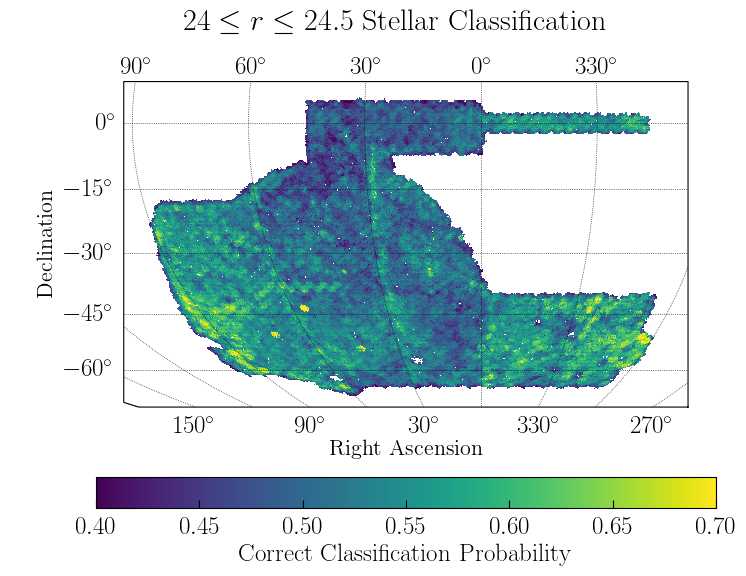

In [36]:
# # The default DES projection is a McBrydeSkymap.
# fig = plt.figure(1, figsize=(8, 6))
# ax = fig.add_subplot(111)
# sp = skyproj.DESSkyproj(ax=ax)
# sp.draw_hspmap(hspStarCorrProb, cmap = 'viridis')
# plt.clim(0.4, 0.7)
# plt.colorbar(location = 'bottom', label = 'Correct Classification Probability')
# fig.suptitle(r'$24\leq r \leq 24.5$ Stellar Classification', y = 1.02)
# plt.show()

In [31]:
# This generates the fracDet data.
fracFile = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/fracdet/y3a2_griz_o.4096_t.32768_coverfoot_EQU.fits.gz'
fracData = fitsio.read(fracFile)

# This degrades it to 512 resolution and applies a cut to where there is at least 75% coverage.
fracPix = fracData['PIXEL']
fracDet = fracData['SIGNAL']
fracMap = np.full(12*(4096**2), 0.0)
fracMap[fracPix] = fracDet
fracMap = hp.ud_grade(fracMap, res, order_in = 'NESTED', order_out = 'NESTED')
fracPix = np.where(fracMap >= 0.75)[0]

In [32]:
origStar = np.full(len(validPix), 0.0)
for i in np.arange(5):#numMagBins):
    origStar = origStar + claStar[i]
    
origGala = np.full(len(validPix), 0.0)
for i in np.arange(5):#numMagBins):
    origGala = origGala + claGala[i]

In [33]:
corrStarBins = []
corrGalaBins = []
for i in np.arange(5):#numMagBins):
    
    obsStars = (((galaCorrProb[i] * claStar[i]) + ((galaCorrProb[i] - 1) * claGala[i])) / ((starCorrProb[i] + galaCorrProb[i] - 1))).astype(float)
    obsStars[np.where(obsStars < 0)] = 0
    obsStars[np.where(obsStars >= claStar[i] + claGala[i])] = claStar[i][np.where(obsStars >= claStar[i] + claGala[i])] + claGala[i][np.where(obsStars >= claStar[i] + claGala[i])]
    
    obsGalas = claStar[i] + claGala[i] - obsStars
    
    CsfOs = obsStars * starCorrProb[i]
    CsfOg = obsGalas * (1 - galaCorrProb[i])
    
    CgfOs = obsStars * (1 - starCorrProb[i])
    CgfOg = obsGalas * galaCorrProb[i]
    
    CsfOsCorr = CsfOs / (starDetProb[i].astype(float) / aveStarDet[i])
    CsfOgCorr = CsfOg / (galaDetProb[i].astype(float) / aveGalaDet[i])
    
    CgfOsCorr = CgfOs / (starDetAsGalaProb[i].astype(float) / aveStarDetAsGala[i])
    CgfOgCorr = CgfOg / (galaDetAsGalaProb[i].astype(float) / aveGalaDetAsGala[i])
    
    # corrStarBins.append(CsfOsCorr + CsfOgCorr)
    # corrGalaBins.append(CgfOsCorr + CgfOgCorr)
    
    corrStarBins.append(obsStars)# / starDetAsAnyProb[i].astype(float))
    corrGalaBins.append(obsGalas)# / galaDetAsAnyProb[i].astype(float))

In [34]:
corrStar = np.sum(corrStarBins, axis = 0)
corrGala = np.sum(corrGalaBins, axis = 0)

In [35]:
phoRa, phoDec = hp.pixelfunc.pix2ang(res, np.arange(12*res**2), nest=True, lonlat=True)
phoPix = np.full(12*res**2, False, dtype = bool)
phoPix[np.where((phoRa >= 15) & (phoRa <= 35) & (phoDec >= -60) & (phoDec <= -40))[0]] = True

In [36]:
# milkyWayRA, milkyWayDEC = 310, -55
# middleRA, middleDEC = 30, -30
# sagRA, sagDEC = 35, -5

resForSimPix = 8
simPix = hp.pixelfunc.ang2pix(resForSimPix, 310, -55, nest = True, lonlat = True)
fullSimPix = np.full(12*(resForSimPix**2), hp.UNSEEN)
fullSimPix[simPix] = 1
simPixRes = hp.pixelfunc.ud_grade(fullSimPix, res, order_in='NEST', order_out='NEST')

In [37]:
smoothSigma = .15 * np.pi / 180

fullOrigStar = np.full(12*(res**2), hp.UNSEEN)
fullOrigStar[validPix] = origStar
fullOrigStar[fracPix] = fullOrigStar[fracPix] / fracMap[fracPix]
fullOrigStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullOrigStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN
# fullOrigStar[~phoPix] = hp.UNSEEN
# smoothingWeights = np.zeros(12*(res**2))
# smoothingWeights[np.where(fullOrigStar > 0)[0]] = 1
# smoothingWeights = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(smoothingWeights, n2r = True), sigma = smoothSigma), r2n = True)
# fullOrigStar = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(fullOrigStar, n2r = True), sigma = smoothSigma), r2n = True)
# fullOrigStar[np.where(fullOrigStar > 0)[0]] = fullOrigStar[np.where(fullOrigStar > 0)[0]] / smoothingWeights[np.where(fullOrigStar > 0)[0]]

fullCorrStar = np.full(12*(res**2), hp.UNSEEN)
fullCorrStar[validPix] = corrStar
fullCorrStar[fracPix] = fullCorrStar[fracPix] / fracMap[fracPix]
fullCorrStar[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullCorrStar[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN
# fullCorrStar = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(fullCorrStar, n2r = True), sigma = smoothSigma), r2n = True)
# fullCorrStar[np.where(fullOrigStar > 0)[0]] = fullCorrStar[np.where(fullOrigStar > 0)[0]] / smoothingWeights[np.where(fullOrigStar > 0)[0]]

fullStarRatios = np.full(12*(res**2), hp.UNSEEN)
fullStarRatios[validPix[np.where(origStar != 0)[0]]] = corrStar[np.where(origStar != 0)[0]] / origStar[np.where(origStar != 0)[0]]
fullStarRatios[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullStarRatios[np.where(fullOrigStar <= 0)[0]] = hp.UNSEEN

fullOrigGala = np.full(12*(res**2), hp.UNSEEN)
fullOrigGala[validPix] = origGala
fullOrigGala[fracPix] = fullOrigGala[fracPix] / fracMap[fracPix]
fullOrigGala[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullOrigGala[np.where(fullOrigGala <= 0)[0]] = hp.UNSEEN

fullCorrGala = np.full(12*(res**2), hp.UNSEEN)
fullCorrGala[validPix] = corrGala
fullCorrGala[fracPix] = fullCorrGala[fracPix] / fracMap[fracPix]
fullCorrGala[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullCorrGala[np.where(fullOrigGala <= 0)[0]] = hp.UNSEEN

fullGalaRatios = np.full(12*(res**2), hp.UNSEEN)
fullGalaRatios[validPix[np.where(origGala != 0)[0]]] = corrGala[np.where(origGala != 0)[0]] / origGala[np.where(origGala != 0)[0]]
fullGalaRatios[np.where(fracMap < 0.75)[0]] = hp.UNSEEN
fullGalaRatios[np.where(fullOrigGala <= 0)[0]] = hp.UNSEEN

In [38]:
nside_coverage = 32
hspStarCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrStar)
hspStarOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullOrigStar)
hspStarRatio = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullStarRatios)

hspGalaCorr = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullCorrGala)
hspGalaOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullOrigGala)
hspGalaRatio = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=fullGalaRatios)

In [39]:
galaMin = 0
galaMax = 500

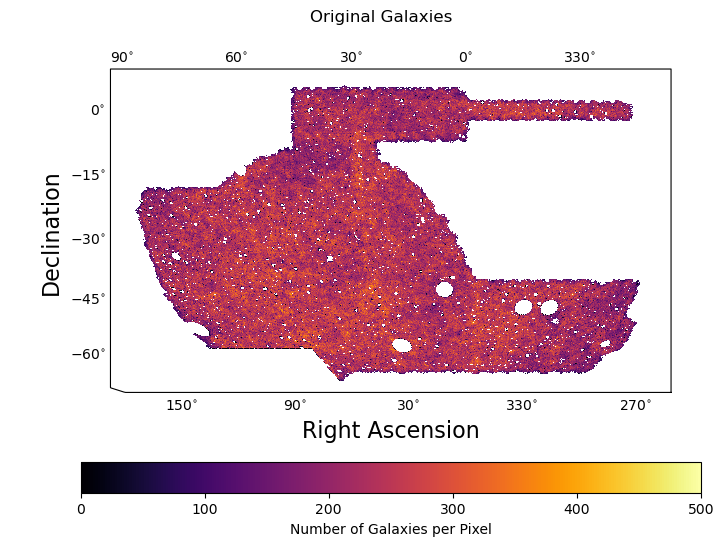

In [40]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax, gridlines = False)
sp.draw_hspmap(hspGalaOrig, cmap = 'inferno')
plt.clim(galaMin, galaMax)
plt.colorbar(location = 'bottom', label = 'Number of Galaxies per Pixel')
fig.suptitle(r'Original Galaxies')
plt.show()

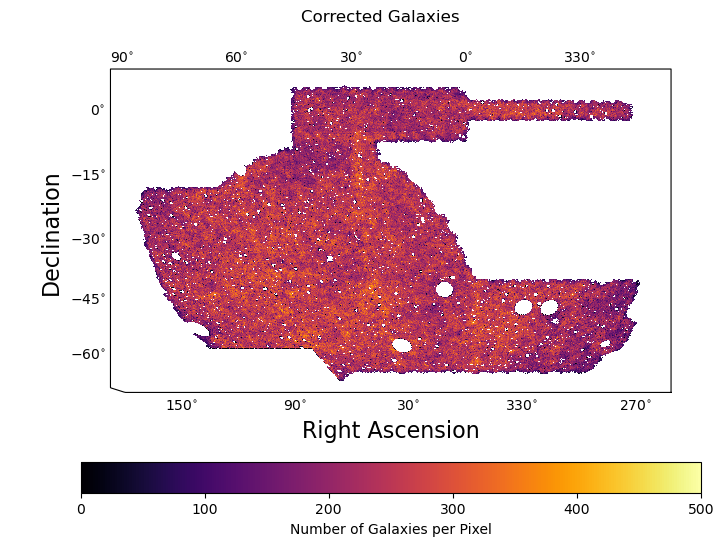

In [41]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax, gridlines = False)
sp.draw_hspmap(hspGalaCorr, cmap = 'inferno')
plt.clim(galaMin, galaMax)
plt.colorbar(location = 'bottom', label = 'Number of Galaxies per Pixel')
fig.suptitle(r'Corrected Galaxies')
plt.show()

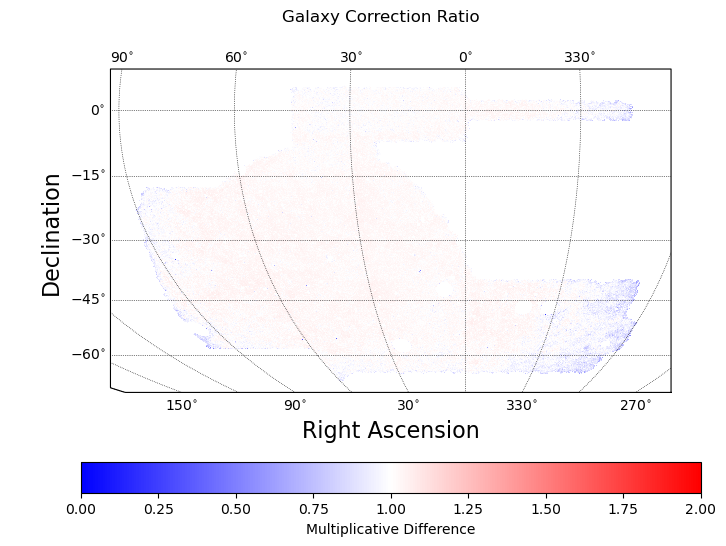

In [42]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax, gridlines = True)
sp.draw_hspmap(hspGalaRatio, cmap = 'bwr')
plt.clim(0, 2)
plt.colorbar(location = 'bottom', label = 'Multiplicative Difference')
fig.suptitle(r'Galaxy Correction Ratio')
plt.show()

In [43]:
starMin = 20
starMax = 50

# Only 5 mag bins.
starMin = 20
starMax = 35

# # Only 4 mag bins.
# starMin = 10
# starMax = 20

# # Galaxy Contamination Correction
# starMin = 20
# starMax = 35

# # Full Sky 5 bins
# starMin = 0
# starMax = 80

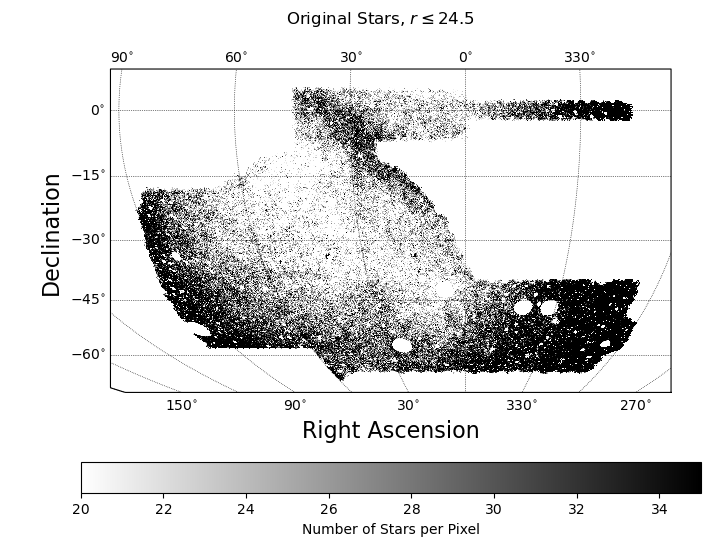

In [44]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax, gridlines = True)
sp.draw_hspmap(hspStarOrig, cmap = 'gray_r')
plt.clim(starMin, starMax)
# plt.clim(0, 125)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'Original Stars, $r\leq 24.5$')
plt.show()

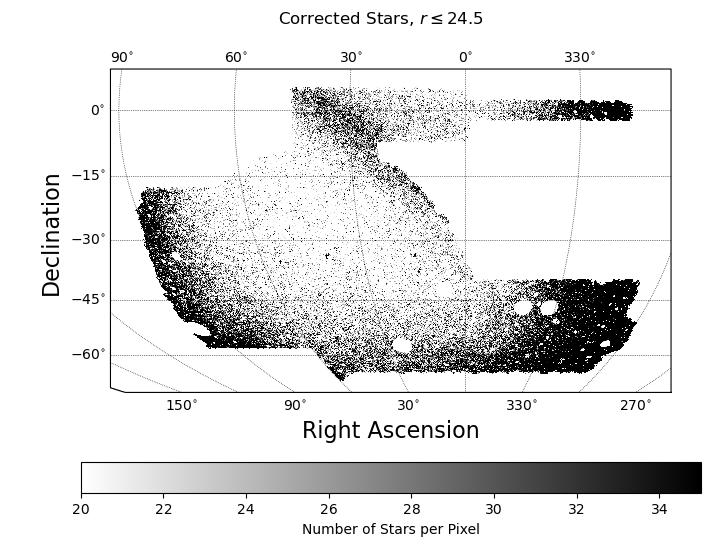

In [45]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax, gridlines = True)
sp.draw_hspmap(hspStarCorr, cmap = 'gray_r')
plt.clim(starMin, starMax)
# plt.clim(0, 125)
plt.colorbar(location = 'bottom', label = 'Number of Stars per Pixel')
fig.suptitle(r'Corrected Stars, $r\leq 24.5$')
plt.show()

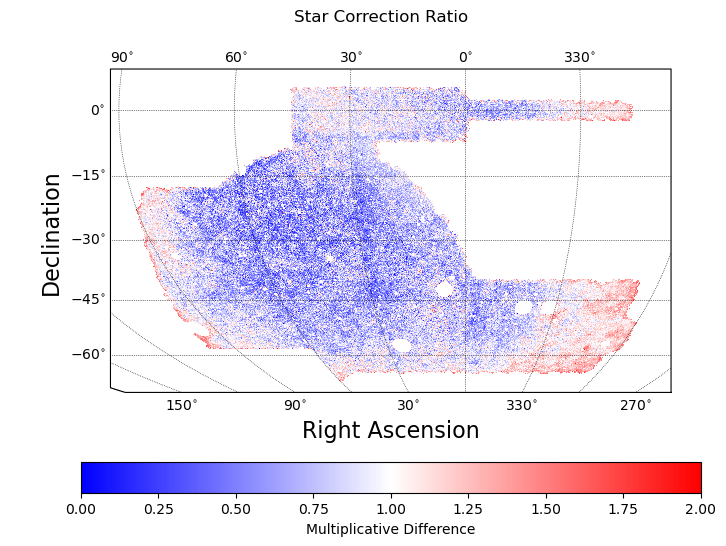

In [46]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax, gridlines = True)
sp.draw_hspmap(hspStarRatio, cmap = 'bwr')
plt.clim(0, 2)
plt.colorbar(location = 'bottom', label = 'Multiplicative Difference')
fig.suptitle(r'Star Correction Ratio')
plt.show()

## Galaxy Dependency Shifts

In [47]:
galaPix = np.where(fullOrigGala >= 0)[0]
origGalaCounts = fullOrigGala[galaPix]
corrGalaCounts = fullCorrGala[galaPix]

aveOrigCount = np.sum(origGalaCounts) / len(origGalaCounts)
aveCorrCount = np.sum(corrGalaCounts) / len(corrGalaCounts)

In [48]:
# import matplotlib.style
# import matplotlib

# matplotlib.style.use('des_dr1')

# for condInd in range(len(Config.conditions)):

#     condition = Config.conditions[condInd]
#     condValues = fitsio.read(strConfig.condFiles[condInd])['SIGNAL']
#     fullCond = np.zeros(12*512**2)
#     fullCond[validPix] = condValues
#     condValues = fullCond[galaPix]

#     x = np.linspace(np.average(condValues)-3*np.std(condValues), np.average(condValues)+3*np.std(condValues), numBins)
#     x = x[np.where(x <= np.max(condValues))[0]]
#     x = x[np.where(x >= np.min(condValues))[0]]
#     galaSigma = sigma * np.std(condValues)
#     yOrig = []
#     yCorr = []

#     for xi in x:
#         # Gaussian weighting the values close by to each x value.
#         totOrigWeightedCounts = np.sum(origGalaCounts * np.exp(-1*(((condValues - xi) / galaSigma)**2)))
#         totOrigWeightedPixels = np.sum(np.exp(-1*(((condValues - xi) / galaSigma)**2)))
#         yOrig.append((totOrigWeightedCounts / totOrigWeightedPixels) / aveOrigCount)

#         totCorrWeightedCounts = np.sum(corrGalaCounts * np.exp(-1*(((condValues - xi) / galaSigma)**2)))
#         totCorrWeightedPixels = np.sum(np.exp(-1*(((condValues - xi) / galaSigma)**2)))
#         yCorr.append((totCorrWeightedCounts / totCorrWeightedPixels) / aveCorrCount)

#     yOrig = np.array(yOrig)
#     yCorr = np.array(yCorr)
    
#     fig, ax1 = plt.subplots()

#     ax1.set_xlabel(condition)
#     ax1.tick_params(axis='y')
#     ax1.set_ylabel(r'$N / \langle N\rangle$')
#     ax1.plot(x, yOrig, label = 'Original Galaxies')
#     ax1.plot(x, yCorr, label = 'Corrected Galaxies')
#     ax1.axhline(y = 1, color = 'black', linestyle = '--')
#     ax1.grid()
#     ax1.legend()

#     ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#     ax2.tick_params(axis='y')
#     ax2.set_ylabel('Fraction of Pixels in Condition Bin')
#     ax2.hist(condValues, bins = np.linspace(np.min(x), np.max(x), 21), color = 'green', rwidth = 0.923, alpha = 0.2, weights = np.ones(len(condValues)) / len(condValues))

#     ax3 = ax1.twinx()
#     ax3.tick_params(axis='y', right = False, labelright = False)
#     ax3.plot(x, yOrig)
#     ax3.plot(x, yCorr)
#     ax3.axhline(y = 1, color = 'black', linestyle = '--')


#     fig.tight_layout()  # otherwise the right y-label is slightly clipped
#     plt.title('Galaxy Count Dependencies on Survey Property')
#     plt.savefig('CorrectMagsDependencies/' + condition)

#     # plt.figure(dpi = 120)
#     # plt.plot(x, yOrig, label = 'Original Galaxies', zorder = 3)
#     # plt.plot(x, yCorr, label = 'Corrected Galaxies', zorder = 3)
#     # plt.axhline(y = 1, color = 'black', linestyle = '--')
#     # plt.xlabel(condition)
#     # plt.ylabel(r'$N / \langle N\rangle$')
#     # plt.title('Density Dependencies on Survey Property')
#     # plt.legend()
#     # plt.grid(zorder = 0)
#     # plt.savefig('GalaxyDependenciesMeasData/' + condition)

In [49]:
ra, dec = hp.pixelfunc.pix2ang(512, galaPix, nest = True, lonlat = True)

In [50]:
min_sep = 0.4 * (np.pi / 180)
max_sep = 40 * (np.pi / 180)
nbins = 20 #* 2

In [51]:
ra = ra * np.pi / 180
dec = dec * np.pi / 180

In [52]:
import treecorr

In [53]:
cat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=origGalaCounts)
nn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
nn.process(cat)

In [54]:
randCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(origGalaCounts), scale = np.std(origGalaCounts), size = len(origGalaCounts)))
rr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
rr.process(randCat)

In [55]:
xi,varxi = nn.calculateXi(rr=rr)

In [56]:
ocat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=corrGalaCounts)
onn = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
onn.process(ocat)

In [57]:
orandCat = treecorr.Catalog(ra=ra, dec=dec, ra_units='rad', dec_units='rad', w=np.random.normal(loc = np.average(corrGalaCounts), scale = np.std(corrGalaCounts), size = len(corrGalaCounts)))
orr = treecorr.NNCorrelation(nbins = nbins, min_sep = min_sep, max_sep = max_sep)
orr.process(orandCat)

In [58]:
oxi,ovarxi = onn.calculateXi(rr=orr)

In [59]:
r = nn.rnom * 180 / np.pi

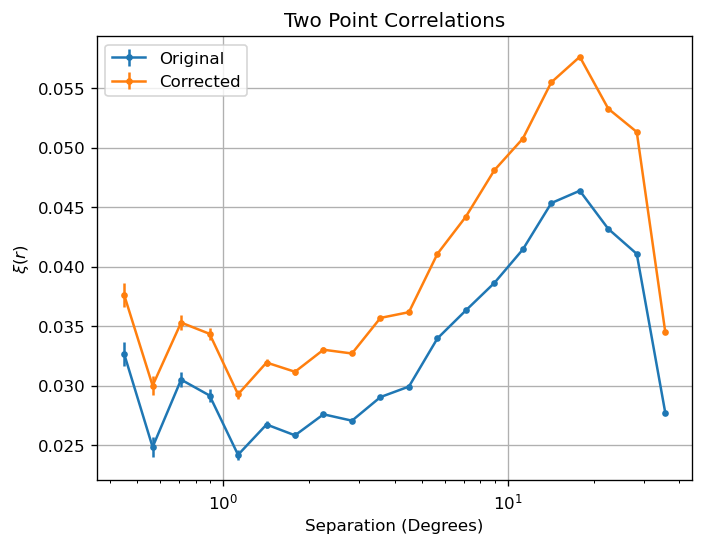

In [60]:
plt.figure(dpi = 120)
plt.errorbar(r, xi, yerr = np.sqrt(varxi), marker = '.', label = 'Original')
plt.errorbar(r, oxi, yerr = np.sqrt(ovarxi), marker = '.', label = 'Corrected')
plt.xlabel('Separation (Degrees)')
plt.xscale('log')
plt.ylabel(r'$\xi\left( r\right)$')
plt.title('Two Point Correlations')
plt.legend()
plt.grid()
ax = plt.gca()
#ax.set_ylim([0, ax.get_ylim()[1]])
plt.show()

## Next Steps:

Crop off the gold objects to just those in the general area of the Phoenix stream. Make a new file that has their RA, DEC, and a weight. Send this to the Phoenix.ipynb file and then check how it looks post rotation. Try to figure out fifth order background and flag cut issues from Peter. The skim files are given names with 32 resolution healpixels which are calculated with RING ordering, not NEST. Use this to get some pixels to skim. Grab the objects from there, and write them to a file along with a weight to send ogre to the Phoenix.ipynb file.

In [61]:
# phoPix32 = hp.ud_grade(phoPix, 32, order_in = 'NESTED', order_out = 'RING')
# phoPix32 = np.where(phoPix32 > 0)[0]

phoPix32 are the files I need to now read.

## Make Sure the Corrections Done Match the Below Mag Cutoff

In [62]:
# StarRA = np.array([])
# StarDEC = np.array([])
# StarWEIGHTS = np.array([])

# phoFiles = []
# for i in range(len(phoPix32)):
#     phoFiles.append(goldObjectsDir + 'y3_gold_2_2_' + f'{phoPix32[i]:0>5}' + '.fits')
    
# for file in phoFiles:
#     obsData = fitsio.read(file, columns = goldCols)
#     FOREGROUND = obsData[goldCols[0]]
#     BADREGIONS = obsData[goldCols[1]]
#     FOOTPRINT = obsData[goldCols[2]]
#     CLASS = obsData[goldCols[3]]
#     GMAG = obsData[goldCols[4]]
#     RMAG = obsData[goldCols[5]]
#     RA = obsData[goldCols[8]]
#     DEC = obsData[goldCols[9]]
#     PIX = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

#     # General Quality Cuts
#     qualityCut = np.where((FOREGROUND == 0) &
#                           (BADREGIONS < 2) &
#                           (FOOTPRINT == 1) &
#                           (pixCheck[PIX]))[0]

#     CLASS = CLASS[qualityCut]
#     GMAG = GMAG[qualityCut]
#     RMAG = RMAG[qualityCut]
#     RA = RA[qualityCut]
#     DEC = DEC[qualityCut]

#     # Observed Star Objects

#     blueStarCut = np.where((CLASS <= classCutoff) & 
#                       (CLASS >= 0) &
#                       (GMAG < gCut))[0]

#     STARRA = RA[blueStarCut]
#     STARDEC = DEC[blueStarCut]
#     STARGMAG = GMAG[blueStarCut]
#     STARRMAG = RMAG[blueStarCut]
    
#     magCut = np.where(STARRMAG <= magBins[-3])
        
#     magStarRa = STARRA[magCut]
#     magStarDec = STARDEC[magCut]
#     magStarGmag = STARGMAG[magCut]
#     magStarRmag = STARRMAG[magCut]

#     isoStarCut = Path.contains_points(path,np.vstack((magStarGmag - magStarRmag, magStarGmag - mu)).T)

#     StarRA = np.append(StarRA, magStarRa[isoStarCut])
#     StarDEC = np.append(StarDEC, magStarDec[isoStarCut])
#     StarWEIGHTS = np.append(StarWEIGHTS, fullStarRatios[hp.pixelfunc.ang2pix(res, magStarRa[isoStarCut], magStarDec[isoStarCut], nest = True, lonlat = True)])

# my_table = Table()
# my_table['RA'] = StarRA.astype(float)
# my_table['DEC'] = StarDEC.astype(float)
# my_table['WEIGHT'] = StarWEIGHTS.astype(float)
# my_table.write(strConfig.phoenixFile, overwrite = True)

## General Balrog Test

Here I will attempt to get counts per 512 pixel of observed stars and observed galaxies to use as weighting in the balrog test. I will just be printing out average count/pixel arrays and copy pasting those in.

In [63]:
obsStarCountPerPixel = []
for i in np.arange(5):
    fullCorrStarBin = np.full(12*(res**2), hp.UNSEEN)
    fullCorrStarBin[validPix] = corrStarBins[i]
    checkStarBin = fullCorrStarBin[np.where(simPixRes > 0)[0]]
    obsStarCountPerPixel.append(np.sum(checkStarBin[np.where(checkStarBin >= 0)[0]]) / len(np.where(checkStarBin >= 0)[0]))
print(obsStarCountPerPixel)  

obsGalaCountPerPixel = []
for i in np.arange(5):
    fullCorrGalaBin = np.full(12*(res**2), hp.UNSEEN)
    fullCorrGalaBin[validPix] = corrGalaBins[i]
    checkGalaBin = fullCorrGalaBin[np.where(simPixRes > 0)[0]]
    obsGalaCountPerPixel.append(np.sum(checkGalaBin[np.where(checkGalaBin >= 0)[0]]) / len(np.where(checkGalaBin >= 0)[0]))
print(obsGalaCountPerPixel)

[11.034763594729077, 5.46824947222127, 5.327817349228764, 15.256181624036115, 30.886590162746476]
[4.415052356191168, 28.718253595263395, 38.06604768144608, 53.82725395878597, 48.4083791624069]


In [64]:
print(np.sum(obsStarCountPerPixel))
print(np.sum(obsGalaCountPerPixel))

67.9736022029617
173.4349867540935
